# Sensor Confirmation
In this notebook the data exploration for Sensor Confirmation will be presented using data recorded from simulation. The mission assumptions about sensor pairs will be explained and visuals to support certain actions will be provided, i.e., offset and scaling of sensor readings. The goal is to determine how feasible Sensor Confirmation is given data readings from a set of independent sensors that resolve to the same information.

-  Sensors Explored
    -  Inertial Measurement Unit (IMU)
        -  Accelerometer
        -  Gyroscope
        -  Magnetometer
    -  Optical Flow (OF)
    -  Rangefinder (RF)
    -  Global Positioning System (GPS)
    -  Barometer
| Sensor Systems                                  | Gyroscope | Accelerometer | Magnetometer | Barometer |  GPS  |   RF  |   OF  | RF & OF | RF & OF &<br>  (Gyroscope \|\|  Magnetometer) | Accelerometer &<br>  (Gyroscope \|\|  Magnetometer) |
|-------------------------------------------------|:---------:|:-------------:|:------------:|:---------:|:-----:|:-----:|:-----:|:-------:|:-----------------------------------------:|:-----------------------------------------------:|
| Gyroscope                                       |     -     |               |     **x**    |           |       |       | **x** |         |                     -                     |                        -                        |
| Accelerometer                                   |     -     |       -       |              |   **x**   |       | **x** |       |  **x**  |                   **x**                   |                        -                        |
| Magnetometer                                    |     -     |       -       |       -      |           |       |       | **x** |         |                     -                     |                        -                        |
| Barometer                                       |     -     |       -       |       -      |     -     | **x** | **x** |       |  **x**  |                   **x**                   |                      **x**                      |
| GPS                                             |     -     |       -       |       -      |     -     |   -   | **x** |       |         |                   **x**                   |                      **x**                      |
| RF                                              |     -     |       -       |       -      |     -     |   -   |   -   |       |    -    |                     -                     |                      **x**                      |
| OF                                              |     -     |       -       |       -      |     -     |   -   |   -   |   -   |    -    |                     -                     |                      **x**                      |
| RF & OF                                         |     -     |       -       |       -      |     -     |   -   |   -   |   -   |    -    |                     -                     |                      **x**                      |
| RF & OF &  (Gyroscope \|\|  Magnetometer)       |     -     |       -       |       -      |     -     |   -   |   -   |   -   |    -    |                     -                     |                      **x**                      |
| Accelerometer &  (Gyroscope \|\|  Magnetometer) |     -     |       -       |       -      |     -     |   -   |   -   |   -   |    -    |                     -                     |                        -                        |
***

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

## Data Processing
The log `file` needs to be parsed out as the format is irregular, starting with
a csv of rows prefixed with FMT, indicating the log type and format. The FMT
rows will be parsed into headers and then the subsequent rows will be matched
on log name, i.e., "__SNS1__", "__SNS2__", "__SNS3__" and added to their
respective dataframes. The dataframes are then unioned on their timestamps to
create a single dataframe with all of the __SNS__ data. If an `output` path is
provided the newly created dataframe will be written to the path as a CSV.

In [2]:
import pandas as pd
import numpy as np
from confirmation.process import process_SNS
from os.path import exists

#Convert log file from Mission Planner to usable CSV
data_dir = "../data/"
file = "Sim-C-Delivery.log" #Change file for different log files
output = data_dir + "interim/" + file[:-3] + "csv"

#Check if file exists already and if it does skip processing and read the file
if not exists(output):
    #Open log file and parse out the SNS data into pandas dataframes
    df = process_SNS(data_dir + "raw/" + file, output)
else:
    df = pd.read_csv(output)

#All of the data is numeric and should be treated as such
df = df.apply(pd.to_numeric)

## Gyroscope, Magnetometer, and Optical Flow
Gyroscopes, Magnetometer, and Optical Flow are related in that they provide 
attitude information. Gyroscopes provide angular rate information, 
Magnetometers provide magnetic field information which can be used with local
corrections to determine heading, and Optical Flow can provide pitch and roll
rate information.

The __gyroscopes__ we generally use are the ones embedded in the
ArduPilot flight controllers which are microelectromechanical systems
(MEMS) gyroscopes. MEMS gyroscopes measure angular rate using the Coriolis
effect. The angular rate by itself can be used as change in attitude but
can also see use in systems such as dead reckoning where a starting attitude
is known and the angular rate is integrated over time to rotate the attitude.
A known issue with dead reckoning however is integration drift, where the
attitude will drift from the true attitude due to integrating noise in the
angular rate readings.

The __magnetometer__ is used for pitch and yaw information. By measuring
the magnetic field and compensating for local magnetic declination the
pitch and yaw can be established. ArduPilot primarily uses the magnetometer for
heading correction which represents the yaw. Several yaw measurements
can be used to determine the angular rate of the system which can be
confirmed directly to the gyroscope angular roll and yaw measurements.

__Optical flow__ is primarily a camera sensor with an optical flow algorithm
running on the images. In our setup we use an OpenMV H7 Plus camera sensor with
the example optical flow code which uses phase correlation, see the following
link for more information:
https://docs.openmv.io/library/omv.image.html#image.image.Image.image.find_displacement
For confirmation the relevant detail is that optical flow gives roll rate and
pitch rate which can be integrated like with dead reckoning to determine a new
attitude assuming an initial attitude.

The three sensors above represent the ways a gyroscope can be confirmed with
other sensors without involving entire sensors systems. Worth noting is the
asymmetric relationship present amongst these sensors. Magnetometer can give
pitch and yaw information, gyroscope can give complete angular rates, while
optical flow can only give pitch and roll information.

#### Gyroscope
Gyroscope inherently provides angular rate which can be confirmed to the 
changes in magnetometer-derived change in attitude. If we were to confirm
directly to the magnetometer-derived attitude instead we would need to
integrate the gyroscope readings.

Here is a plot of the gyroscope readings showing rotation about the z axis,
representing the yaw of the quadcopter.

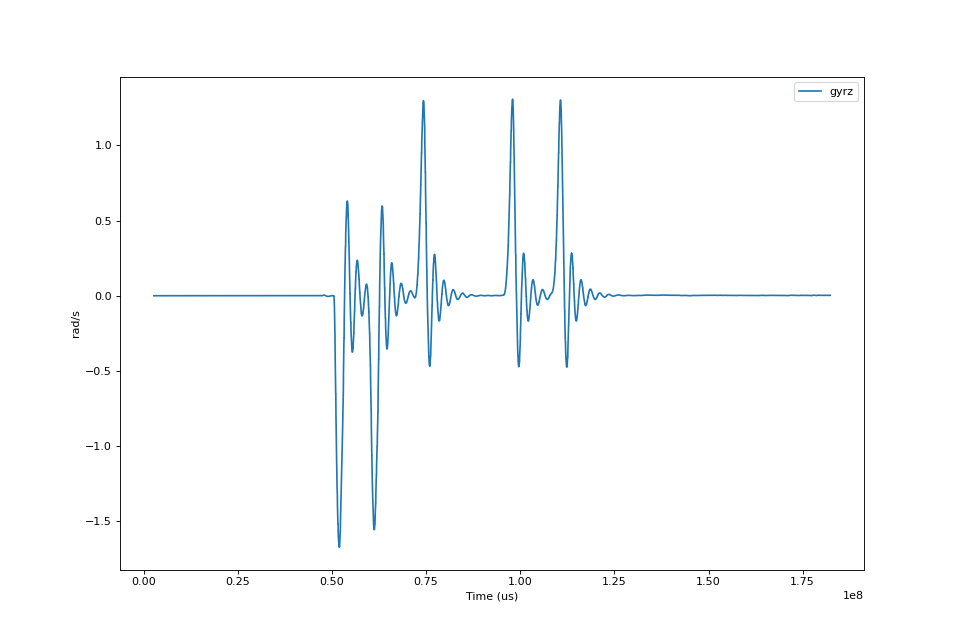

In [3]:
from confirmation.visualize import simple_time_plot

simple_time_plot(df.TimeUS, df['gyrz'], ["us","rad/s"])

The signal we are seeing, _gyrz_, represents the change in the yaw. The expectation is if we ***start from a heading of 0 degrees***, with a clockwise rotation rotation about the z axis being positive, and integrate _gyrz_ over time we should get the heading at any given time assuming ***pitch and roll are accounted for***. The important detail being we have a known initial state to integrate from, a commonly known method of attitude estimation that is involved with dead reckoning. Below is the heading if we were to integrate the gyroscope over time with trapezoidal integration and summed the changes over time while ***assuming a level platform the entire flight***:

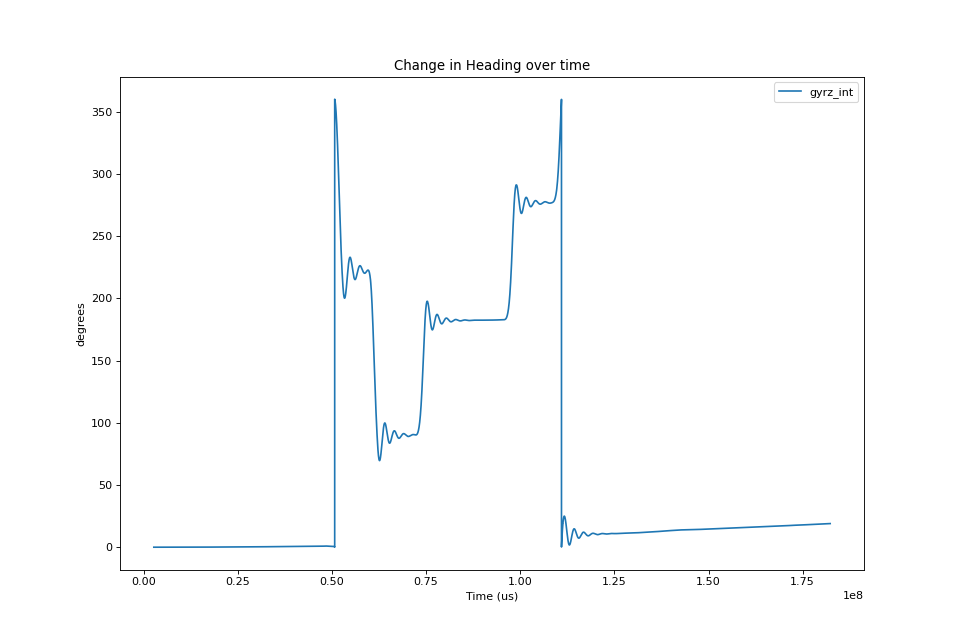

In [4]:
from confirmation.process import trap_integrate
from math import degrees

gyr_heading = trap_integrate(df.cUS / 1000000, df.gyrz).apply(degrees).cumsum() % 360
simple_time_plot(df.TimeUS[1:], gyr_heading, ['us', 'degrees'], title="Change in Heading over time")

### Magnetometer
ArduPilot primarily uses the magnetometer for yaw corrections and will 
similarly be used here for comparison to the gyroscopes determined yaw. An
important consideration for confirmation is that the gyroscopes and
mangetometer only measure yaw when the platform is level, with no pitch or
roll. If the platform is not level however then tilt compensation can be done
with an accelerometer to get heading information from the magnetometer while
the gyroscope can perform dead reckoning from a level position to estimate the
actual attitude. In the below heading calculations we will assume a level
platform as before with the gyroscope. The reference formulas for the heading
and pitch calculation are found and derived from information provided in
the
[AN203 reference](../references/AN203_Compass_Heading_Using_Magnetometers.pdf).

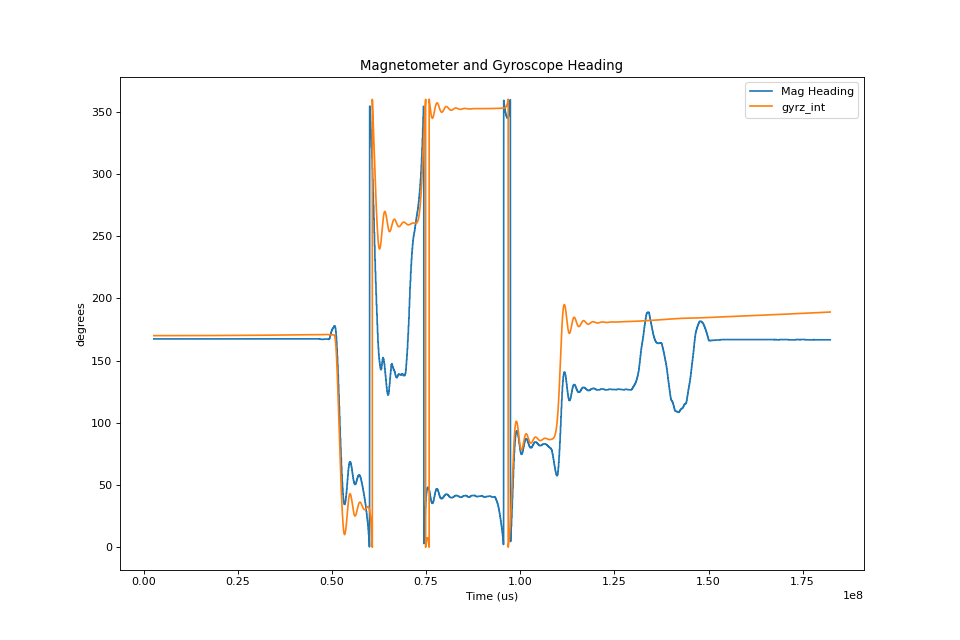

In [5]:
from confirmation.process import mag_to_heading

mag_heading = mag_to_heading(df.magz, df.magy, df.magx)
simple_time_plot([df.TimeUS[1:], df.TimeUS[1:]],
                 [(mag_heading[1:]-180)%360, (gyr_heading+170)%360],
                 ["us","degrees"],
                 title="Magnetometer and Gyroscope Heading")

***TODO:*** Magnetomere and Gyroscope aren't aligned well but demonstrate
yawing activity at the same timestamps. Need to lookover the magnetometer
calculation again and consider adding the accelerometer tilt compensation. An
important consideration here is that the last yaw should result in a south
facing direction, or 180 degrees. The magnetometer derived heading here points
north indicating an offset of 180 degrees. Also worth noting is the yaw scale
seems to be off. The turns should be approximately 90 degrees each time but the
magnetometer is indicating ~45 degrees.

Just as before, the pitch rate of the gyroscope and magnetometer can be
confirmed to one another. Same approach is taken with the same assumptions
and restrictions:

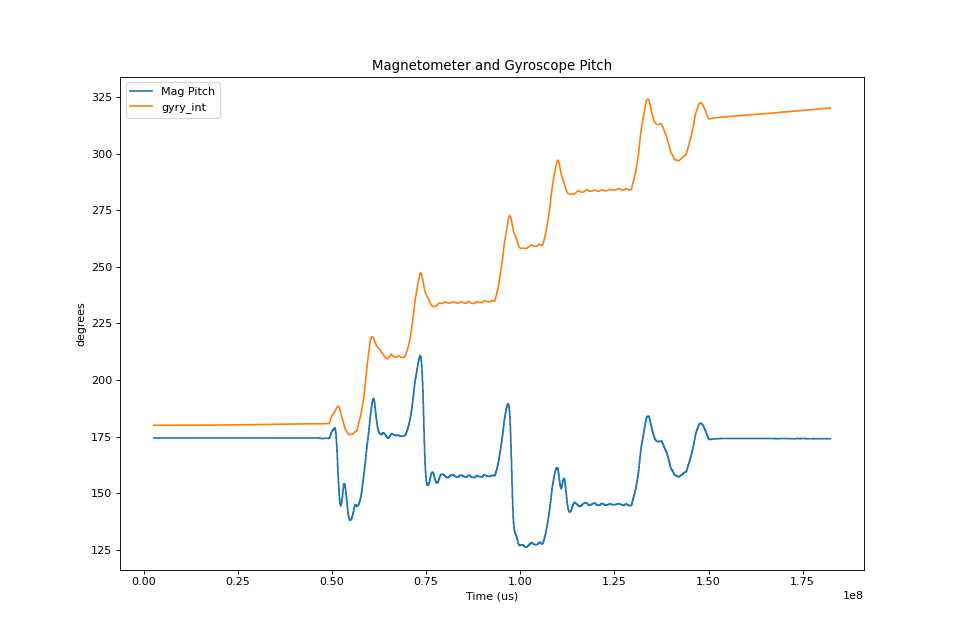

In [6]:
from confirmation.process import mag_to_pitch

#Gyroscope pitch, same as before with heading
gyr_pitch = trap_integrate(df.cUS / 1000000, df.gyry).apply(degrees).cumsum() % 360

#Magnetometer pitch
mag_pitch = mag_to_pitch(df.magz, df.magy, df.magx)
simple_time_plot([df.TimeUS[1:], df.TimeUS[1:]], [(mag_pitch[1:]+180)%360, (gyr_pitch+180)%360], ["us","degrees"], title="Magnetometer and Gyroscope Pitch")

***TODO:*** Similarly to before with the gyroscope and magnetometer, the change in signals are similar at corresponding timestamps but the actual scales are off. Consider the previous figure at Time=0.75. The decrease in degrees of pitch follows the same trend but the magnitude of which the pitch changes in the magnetometer is far greater. The same caveat applies as before where the gyroscope is reading the change in pitch while the magnetometer is reading the absolute pitch meaning the gyroscope derived pitch is offset but the initial value.

### Optical Flow
Optical Flow calculates the pitch and roll rates, referred to as flow rates in
ArduPilot, from sequential images taken from a camera. An important caveat to
this system is the ***perceived flow rates can be skewed by tilting***. If for
example the platform were to remain still but tilt then there would be a
measured flow rate corresponding to the body rate. If the platform were to stay
level with the ground surface but move around there would be a measured flow
rate corresponding to the angle of movement of the perceived pixels. The latter
situation is how optical flow velocity is derived while the former indicates
a limitation to confirmation between the gyroscope and optical flow. A typical
use case would see the optical flow sensor tuned to the gyroscope to better
remove body rate from flow rate readings and increase optical flow velocity
accuracy.

Below we will address the simpler case, gyroscope and optical flow, but
acknowledge the limitation of optical flow and the likelihood that the optical
flow readings will only match the gyroscope during times of litle to no
movement:

In [7]:
simple_time_plot(df.TimeUS, [df.frR, df.gyrx], units=["us","rad/s"], title="Optical Flow and Gyroscope Roll Rate")

Mismatched timestamp and signal lengths: 71852 Timestamps, 2 Signals


The interesting regions here are the 3 vertical spikes in the center of the
signal. These regions correspond to the quadcopter during the delivery mission
making right turns at which the quad slows down. Since the quad slows down to
take the corners the perceived flow rate is primarily coming from the body rate
which the gyroscope is directly measuring. The main takeaway from this data is
that ***optical flow and gyroscope confirmation is feasible during loiter***.
Just as before with the roll rate the pitch rate will be shown below:

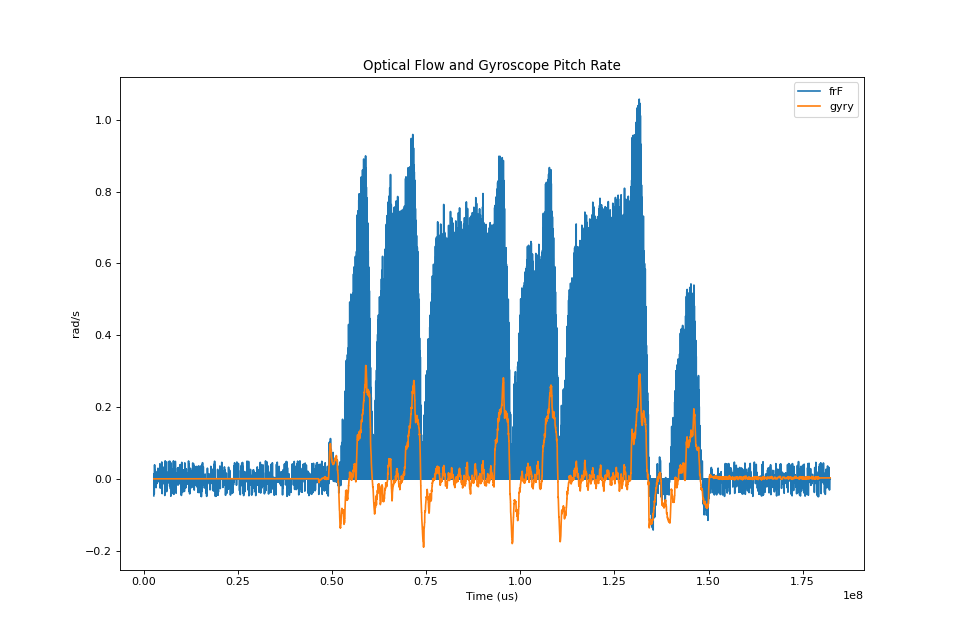

In [8]:
simple_time_plot([df.TimeUS, df.TimeUS], [df.frF, df.gyry], units=["us","rad/s"], title="Optical Flow and Gyroscope Pitch Rate")

The difference in pitch is far more drastic as the quadcopter during this
mission was primarily moving forward. The forward motion of the quadcopter is
reflected as a positive flow rate and is reflected in the signal seen in the
above figure. There are moments where the quadcopter slows down to take a
corner and the signals overlap better but overall the useful points of
confirmation is ***what action is being taken rather than what magnitude of
action***.

The final potential pair of sensors that can confirm one another are the
optical flow and magnetometer roll rates. To confirm the optical flow and
magnetometer roll rates either the optical flow needs to be integrated or the
magnetometer needs to be derived. To follow the gyroscope and magnetometer
implementation the optical flow will be integrated and compared to the
magnetometer.

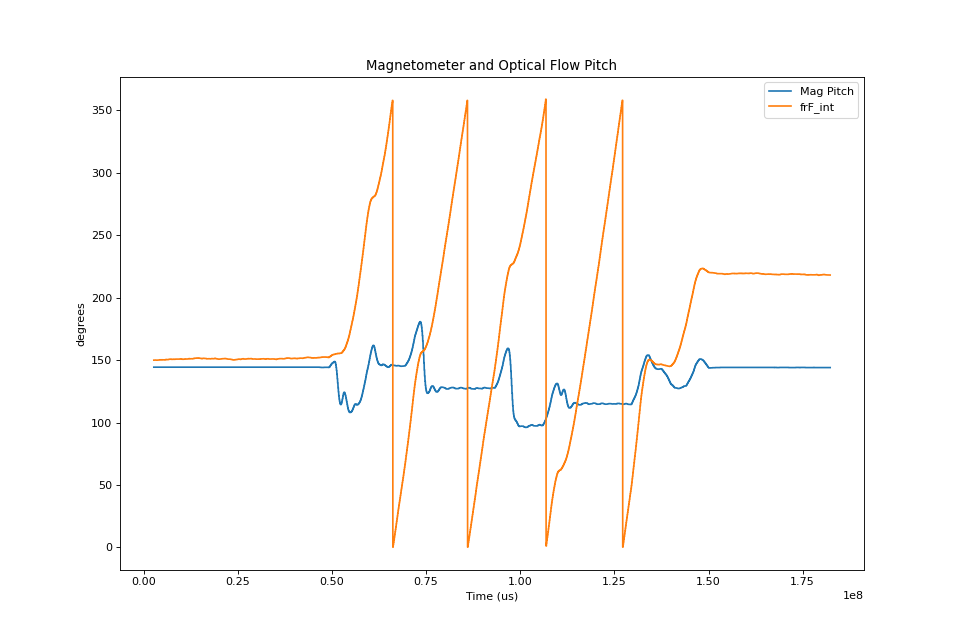

In [9]:
#Optical flow pitch, same as before with roll
of_pitch = trap_integrate(df.ofUS / 1000, df.frF).apply(degrees).cumsum() % 360

#Using the pitch derived from magnetometer from before
simple_time_plot([df.TimeUS[1:], df.TimeUS[1:]], [(mag_pitch[1:]+150)%360, (of_pitch+150)%360], ["us","degrees"], title="Magnetometer and Optical Flow Pitch")

The magnetometer and optical flow pitch are not alike which is not too surprising. In Figure 6 the pitch rate of the optical flow sensor was displayed which indicated significant positive pitching which corresponds to measuring the flow rate under the quadcopter and not the body rate. A quadcopter can only fly forward by pitching forward which is what is being captured and does not reflect the attitude the magnetometer measures. There is some behavior at points of fluxuation where oscillation in the attitude as shown by the magnetometer shows fluxuations in the optical flow but otherwise ***there is not an easily discerned method of confirmation***.

## GPS specific
Looking at specifically the GPS sensor there isn't an inherent value being
measured that can be directly compared to inertial sensors such as angular
rate. Instead, we will take a look at the different ways a GPS can be confirmed
even if each sensor pairing does not have an application to another sensor
pair. An example of this is using a barometer to confirm the GPS height
estimate while using the magnetometer to confirm the GPS heading (assuming
conditions are met).

__GPS__ provides positional data which is derived from information provided by
satellites and the signals used to transmit that information. A consequence of
using several satellites for position calculation is the absolute measurements
will have less accuracy depending on world model but the relative measurements
will still have decent accuracy. Below will be a list of confirmations we will
explore in this:

| **Measurement**             | **Rangefinder** | **Barometer** | **Magnetometer** | **Gyroscope** | **RF & OF** |   **Accelerometer &  (Gyroscope \|\| Magnetometer)**|
|-----------------------------|-----------------|---------------|------------------|---------------|-------------|-----------------------------------------------------|
| Above-Ground-Level Distance |      **x**      |     **x**     |                  |               |    **x**    |                        **x**                        |
| Heading                     |                 |               |       **x**      |     **x**     |             |                        **x**                        |
| Speed                       |                 |               |                  |               |    **x**    |                        **x**                        |

### Above-Ground-Level Distance

A commonly used measurement for navigation systems is the above-ground-level
(AGL) distance reading. A common requirement of flight is to maintain a certain
AGL distance for safety concerns, whether the drone needs a certain amount of
height to recover from system malfunction or simply avoiding being near people.
GPS systems calculate the AGL height by calculating their global position and
comparing the result to a world model, i.e., World Geodetic System 1984 (WGS84)
. 

A __rangefinder__ can get ranging measurements through different mediums. The
primary two types seen on quadcopters, and both present on the test platform,
are lidar and sonar rangefinders. Lidars generally have a higher range and
better accuracy but are suspectible to mediums altering readings such as dusty
environments or translucent surfaces. Sonars tend to be less suspectible to the
what they are measuring and can detect distance to clear objects but have a 
much shorter operating range. Typically, a lidar will be implemented for
general use but sonars see inclusion for landing systems. In the analysis that
follows the ranging sensor will be the lidar.

A __barometer__ measures the ambient pressure to determine altitude. Typically
the AGL height is determined as above-sea-level height when using a barometer
but for ease of use with the quadcopter platform the barometer calibrates to
the pressure at the launch point and calculates the relative altitude to the
launch point. Temperature measurements are used in the barometer to improve
accuracy with temperature compensation.

__RF & OF__ were included in the table but the primary reason is because of the
involvement of the RF. Refer to the previous section on the rangefinder for
details.

__Accelerometer__ can be used for AGL height in a similar fashion as the
barometer where an initial measurement is required and a height estimation is
made by integrating the accelerometer readings. A caveat of this approach is
knowing which way down is which is generally done by determining the gravity
vector but can become less accurate as other forces are acting. Given a drone
that is moving only on the z axis the AGL height estimation becomes easier and
less noisy.

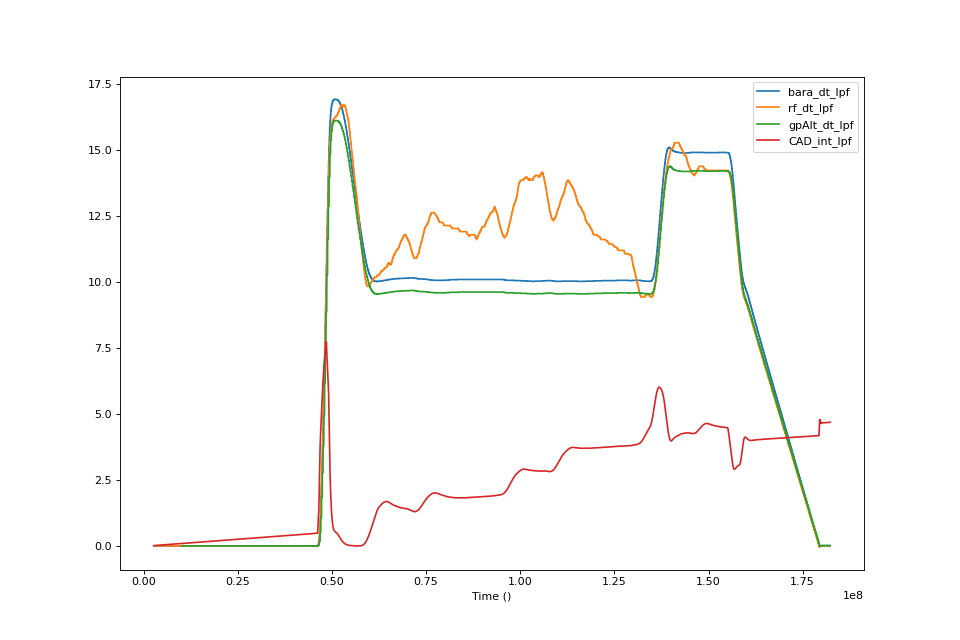

In [10]:
#Need both the low pass filter to reduce noise and change_in_signal to compare
#change rather than raw value
from confirmation.process import low_pass_filter, change_in_signal

acc_alt = low_pass_filter(trap_integrate(df.cUS/1000000, -df["CAD"]), 1).cumsum()
bar_alt = low_pass_filter(change_in_signal(df.bara), 1).cumsum()
rf_alt = low_pass_filter(change_in_signal(df.rf/100), 1).cumsum()
gp_alt = low_pass_filter(change_in_signal(df.gpAlt[3000:].reset_index(drop=True)/100), 1).cumsum()

simple_time_plot([df.TimeUS[1:], df.TimeUS[1:], df.TimeUS[3001:], df.TimeUS[1:]],
                 [bar_alt, rf_alt, gp_alt, acc_alt])

### Velocity

Speed is a difficult measurement to use for confirmation, especially velocity,
as the added number of sensors increases the error margins of the results. For
velocity we are more reliant on the relative readings of the GPS to get the
advertised speed accuracy in the documentation, 0.05m/s, rather than looking
at absolute position data. An important consideration when doing confirmation
of velocity is the reference frame confirmation takes place in. When looking
primarily at the GPS the measurements for velocity will be in an Earth-Centered
Earth-Fixed (ECEF) frame with the velocity measurements being along the north,
east, and down axis. The reference frame is important because while the GPS is
in an ECEF frame, the other sensors such as OF, RF, accelerometer, gyroscope,
and magnetometer are in body frame with the center of the sensor